# Homer Summary

Summarize Homer runs across peak sets in a bubble plot similar to Fig 2H in Knaupp et al 2017

<img src="./data/Knaupp_2017_fig2H.png" width="800">

In [161]:
library(ggplot2)
library(scales)
library(ggplotify)

## Load TF List

Can come by running TF-MoDISco or similar on samples and matching motifs to closest known HOMER motif (using TomTom, say).

In [35]:
# motif_list = read.table("tf_list.tsv")
# rownames(motif_list) = motif_list$V1
# colnames(motif_list) = c("motif", "freq")
# head(motif_list, 2)
# dim(motif_list)

# motif_list = motif_list[motif_list$freq>1,]
# dim(motif_list)
# tail(motif_list)

In [104]:
motif_list = read.table("20220103_curated_tf_list.tsv")
rownames(motif_list) = motif_list$V1
colnames(motif_list) = c("motif")
head(motif_list, 2)
dim(motif_list)

,motif
,<fct>
REST-NRSF(Zf)/Jurkat-NRSF-ChIP-Seq/Homer,REST-NRSF(Zf)/Jurkat-NRSF-ChIP-Seq/Homer
BORIS(Zf)/K562-CTCFL-ChIP-Seq(GSE32465)/Homer,BORIS(Zf)/K562-CTCFL-ChIP-Seq(GSE32465)/Homer


[1] 29  1

## Load HOMER Data

In [105]:
BASE_PATH = "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/"

samples = list.files(BASE_PATH)
samples = samples[order(nchar(samples), samples)]
samples = samples[grep("idx", samples)]
samples

[1] "idx1"  "idx2"  "idx3"  "idx4"  "idx5"  "idx6"  "idx7"  "idx8"  "idx9" 
[10] "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17" "idx18"
[19] "idx19" "idx20"

In [129]:
homer_outputs = paste(BASE_PATH, samples, "/knownResults.txt", sep='')
homer_outputs

[1] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx1/knownResults.txt" 
 [2] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx2/knownResults.txt" 
 [3] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx3/knownResults.txt" 
 [4] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx4/knownResults.txt" 
 [5] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx5/knownResults.txt" 
 [6] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx6/knownResults.txt" 
 [7] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx7/knownResults.txt" 
 [8] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx8/knownResults.txt" 
 [9] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx9/knownResults.txt" 
[10] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx10/knownResults.txt"
[11] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx11/knownResults.txt"
[12] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx12/knownResults.txt"
[13] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx13/knownResults.txt"
[14] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx14/knownResults.txt"
[15] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx15/knownResults.txt"
[16] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx16/knownResults.txt"
[17] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx17/knownResults.txt"
[18] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx18/knownResults.txt"
[19] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx19/knownResults.txt"
[20] "../20200307_fine_clustering/homer/20210719_gridmap_peakwidthnorm_logplusznorm_4way_assited_n20/idx20/knownResults.txt"

In [130]:
# reads homer Motif.Names (first column) and breaks them into 
# TF name and family name (if available)
# if family name not available, uses name of TF itself
get_tf_fam <- function(homer_motif_names) {
    tfs = c()
    fams = c()
    for (x in as.character(homer_motif_names)) {
        tf_fam = strsplit(x, "/")[[1]][1]
        tf_fam = strsplit(tf_fam, "\\(")[[1]]

        if (length(tf_fam)==2) {
            tf = tf_fam[1]
            fam = sub(")", "", tf_fam[2])
        }

        else {
            tf = tf_fam[1]
            fam = tf
        }
        
        tfs = c(tfs, tf)
        fams = c(fams, fam)
    }
    
    list(tfs, fams)
}

In [131]:
homer_results = list()
for (i in seq(1,length(homer_outputs))) {
    homer_results[[i]] = read.table(homer_outputs[i], sep="\t",header=T, comment.char="")   
    tf_fam = get_tf_fam(homer_results[[i]][,1])
    homer_results[[i]]$TF = unlist(tf_fam[1])
    homer_results[[i]]$TF_family = unlist(tf_fam[2])
}

In [132]:
head(homer_results[[1]],2)

,Motif.Name,Consensus,P.value,Log.P.value,q.value..Benjamini.,X..of.Target.Sequences.with.Motif.of.39004.,X..of.Target.Sequences.with.Motif,X..of.Background.Sequences.with.Motif.of.38846.,X..of.Background.Sequences.with.Motif,TF,TF_family
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<chr>
1,Fra1(bZIP)/BT549-Fra1-ChIP-Seq(GSE46166)/Homer,NNATGASTCATH,0,-19980,0,21070,54.02%,4684.8,12.06%,Fra1,bZIP
2,Atf3(bZIP)/GBM-ATF3-ChIP-Seq(GSE33912)/Homer,DATGASTCATHN,0,-19060,0,22433,57.51%,5710.2,14.70%,Atf3,bZIP


In [133]:
# create consolidated df
consolidated_df = homer_results[[1]][,c(4,7, 10, 11)]
consolidated_df$sample = samples[[1]]

for (i in seq(2, length(homer_results))) {
    cur_df = homer_results[[i]][,c(4,7, 10, 11)]
    cur_df$sample = samples[[i]]
    consolidated_df = rbind(consolidated_df, cur_df)
}

In [134]:
# separate KLF into its own family (current it's with ZF)
consolidated_df$TF_family[grep("KLF", consolidated_df$TF, ignore.case = T)] = "KLF"

In [135]:
# rename etc
consolidated_df$sample = factor(consolidated_df$sample, levels=samples)
colnames(consolidated_df) = c("Log.P.value", "perc.target.seqs.with.motif", "TF", "TF_family", "sample")
consolidated_df$perc.target.seqs.with.motif = as.numeric(sub("%", "", consolidated_df$perc.target.seqs.with.motif))
head(consolidated_df)
dim(consolidated_df)

,Log.P.value,perc.target.seqs.with.motif,TF,TF_family,sample
,<dbl>,<dbl>,<chr>,<chr>,<fct>
1,-19980,54.02,Fra1,bZIP,idx1
2,-19060,57.51,Atf3,bZIP,idx1
3,-18240,56.39,BATF,bZIP,idx1
4,-17670,58.26,AP-1,bZIP,idx1
5,-17450,38.69,Fosl2,bZIP,idx1
6,-15390,31.32,Jun-AP1,bZIP,idx1


[1] 7740    5

In [136]:
length(unique(consolidated_df$TF))

[1] 362

In [137]:
keep_TFs[!keep_TFs %in% consolidated_df$TF]

character(0)

In [138]:
# if motif_list available, filter
keep_TFs = lapply(strsplit(rownames(motif_list), "\\("), "[[", 1)

consolidated_df = consolidated_df[consolidated_df$TF %in% keep_TFs, ]
dim(consolidated_df)
length(unique(consolidated_df$TF))

[1] 540   5

[1] 27

In [139]:
# remove highly correlated TFs per family
# https://stackoverflow.com/questions/18275639/remove-highly-correlated-variables

REMOVE_ABOVE = 0.999

keep_TFs = c()
for (x in unique(consolidated_df$TF_family)) {
    cur_tf_df = consolidated_df[consolidated_df$TF_family==x, c("Log.P.value", "TF", "sample")]
    if (length(unique(cur_tf_df$TF))==1) {
        keep_TFs = c(keep_TFs, unique(cur_tf_df$TF))
        next 
    }
    
    # make TF x sample matrix 
    tf_sample_matrix = matrix(0, nrow=length(unique(cur_tf_df$TF)), ncol=length(unique(cur_tf_df$sample)))
    rownames(tf_sample_matrix) = unique(cur_tf_df$TF)
    colnames(tf_sample_matrix) = unique(cur_tf_df$sample)
    
    for (i in seq(1, dim(cur_tf_df)[1])) {
        tf_sample_matrix[cur_tf_df[i, "TF"], cur_tf_df[i, "sample"]] = cur_tf_df[i, "Log.P.value"]
    }
    
    # reorder TFs to bring those with most log p-value sum
    tf_sample_matrix = tf_sample_matrix[order(rowSums(tf_sample_matrix)), ]
    
    # remove those with high correlation to another
    tf_cor = cor(t(tf_sample_matrix), method='spearman')
    tf_cor[upper.tri(tf_cor)] <- 0
    diag(tf_cor) <- 0
    keep_TFs = c(keep_TFs, 
                 rownames(tf_cor)[!apply(tf_cor,1,function(x) any(x > REMOVE_ABOVE))])

}

length(keep_TFs)

[1] 27

In [140]:
consolidated_df = consolidated_df[consolidated_df$TF %in% keep_TFs, ]
dim(consolidated_df)
length(unique(consolidated_df$TF))

[1] 540   5

[1] 27

In [141]:
# filter
LOG_PVAL_CUTOFF = log(1e-10)
TARGET_CUTOFF = 5

consolidated_df = consolidated_df[consolidated_df$Log.P.value < LOG_PVAL_CUTOFF, ]
consolidated_df = consolidated_df[consolidated_df$perc.target.seqs.with.motif > TARGET_CUTOFF, ]
dim(consolidated_df)

[1] 193   5

In [142]:
# remove SeqBias and Unknown and GFY/GFX
consolidated_df = consolidated_df[!grepl("(SeqBias|Unknown|GFY|GFX)", consolidated_df$TF) ,]

In [143]:
length(unique(consolidated_df$TF))

[1] 24

In [144]:
quantile(consolidated_df$Log.P.value, c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))

0%        10%        25%        50%        75%        90%       100% 
-17670.000  -1840.800   -739.700   -248.800    -85.120    -36.944    -23.110

In [145]:
# determine order of peak sets
peak_set_idxs = lapply(strsplit(as.character(consolidated_df$sample), "idx"), "[[", 2)

max_peak_set = max(as.numeric(peak_set_idxs))

# ensure they are numbers (won't work if some clusters don't have any entry in consolidated_df)
# stopifnot(seq(1,length(unique(peak_set_idxs)))==as.numeric(unique(peak_set_idxs)))

consolidated_df$peak_set_idx = factor(peak_set_idxs,
                               levels=rev(as.character(seq(1,max_peak_set))))

In [146]:
head(consolidated_df)

,Log.P.value,perc.target.seqs.with.motif,TF,TF_family,sample,peak_set_idx
,<dbl>,<dbl>,<chr>,<chr>,<fct>,<fct>
4,-17670.0,58.26,AP-1,bZIP,idx1,1
12,-1043.0,14.39,NF1,CTF,idx1,1
17,-786.9,31.76,RUNX1,Runt,idx1,1
20,-715.3,33.05,FoxL2,Forkhead,idx1,1
49,-285.2,17.17,TEAD2,TEA,idx1,1
56,-225.9,10.54,Atf2,bZIP,idx1,1


In [147]:
TF_family_order = c('POU,Homeobox', 
                    'POU,Homeobox,HMG', 
                    'HMG', 
                    'KLF', 
                    'bZIP', 
                    'Zf', 
                    'AP2', 
                    'TEA',
                    'Runt',
                    'ETS',
                    'CCAAT')
TF_family_order = c(TF_family_order, as.character(unique(consolidated_df$TF_family))[!as.character(unique(consolidated_df$TF_family)) %in% TF_family_order])

consolidated_df$TF_family = factor(consolidated_df$TF_family,
                                  level=TF_family_order)

In [148]:
# use sample order to facet
# sample_order = c("idx3", "idx4", "idx8", "idx20", # constant
#                  "idx10", "idx13", "idx14", "idx17", "idx16", # close
#                  "idx2", "idx5", "idx18", "idx11", "idx19", # early open
#                 "idx1", "idx9", "idx12", "idx15", "idx7", "idx6") # late open

In [181]:
# https://dmitrijskass.netlify.app/2019/06/30/multi-level-labels-with-ggplot2/
# https://www.r-graph-gallery.com/320-the-basis-of-bubble-plot.html
p <- ggplot(consolidated_df, aes(x = TF, 
                            y = peak_set_idx, 
                            size=perc.target.seqs.with.motif,
                            fill=-Log.P.value)) +
geom_point(shape = 21) +
facet_grid(~factor(TF_family), #, levels=sample(unique(consolidated_df$TF_family))),
           scales = "free_x",
          space = "free_x") +
#           switch = "x") +
scale_fill_gradient(low="gray",
                      high="red",
                      limits=c(10, 200),
                      oob=squish,
                      name="- Log P-value") +
scale_size(range = c(.5, 6.5), 
           name="% Target Sequences\nwith Motif") +
ylab("") +
theme_minimal() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
     strip.text.x.top = element_text(angle = 90, hjust=0, vjust=0.5), # rotate TF family text
     panel.spacing = unit(0.05, "lines"), # space between TF families
     text = element_text(size=15), 
     panel.background = element_rect(fill = NA, color = "black", size=1)) # box around TF families

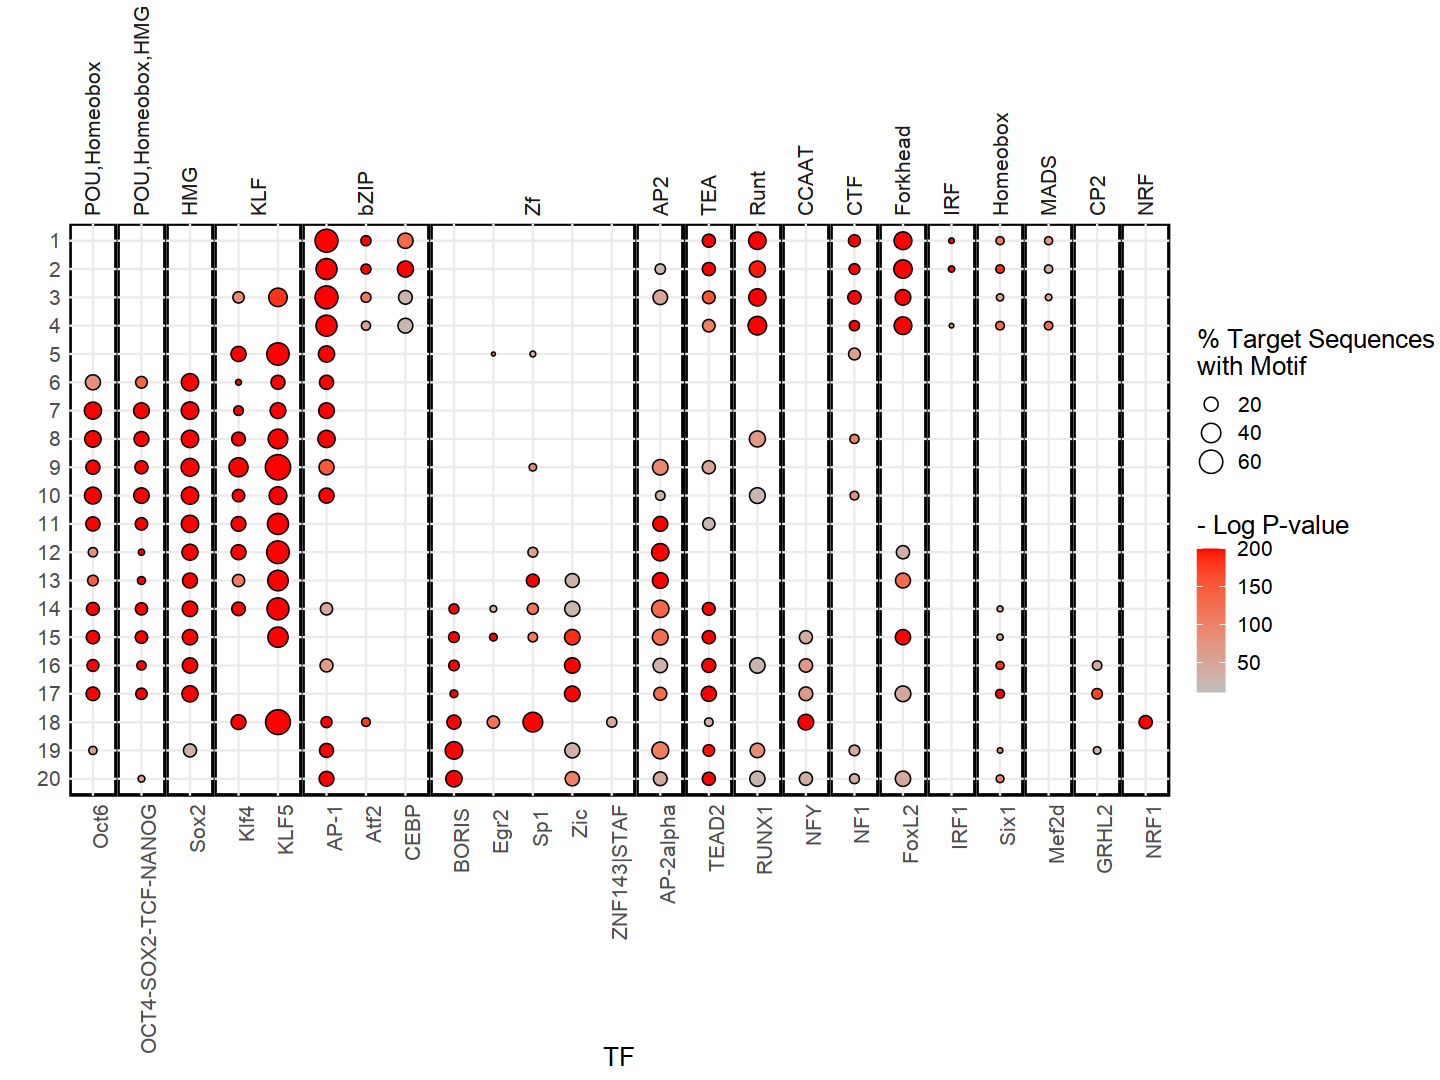

In [182]:
options(repr.plot.width = 12, repr.plot.height = 9)


pg <- ggplotGrob(p)

# avoid stripping of facet label
# https://stackoverflow.com/questions/49740215/ggplot-facet-grid-label-cut-off
for(i in which(grepl("strip-t", pg$layout$name))){
  pg$grobs[[i]]$layout$clip <- "off"
}

grid::grid.draw(pg)

In [183]:
ggsave(pg, file="./outputs/20220103_homer.pdf", height=9, width=12, useDingbats=F)